In [109]:
!pip install scipy==1.11.3

In [110]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Reading Data and Preprocessing

In [111]:
data = sio.loadmat('Data_hoda_full.mat')

images = data['Data']
labels = data['labels']

max_width = 0
max_height = 0
for i in range(len(images)):
  tmp = images[i][0].shape
  if tmp[0] > max_width:
    max_width = tmp[0]
  if tmp[1] > max_height:
    max_height = tmp[1]

def put_frame(image):
  frame_size = (64, 64)
  frame = np.zeros(frame_size, dtype=np.float32)

  x_offset = (frame_size[1] - image.shape[1]) // 2
  y_offset = (frame_size[0] - image.shape[0]) // 2

  frame[y_offset:y_offset + image.shape[0], x_offset:x_offset + image.shape[1]] = image

  return frame

new_data1 = []

for i in range(len(images)):
  new_data1.append(put_frame(images[i][0]))

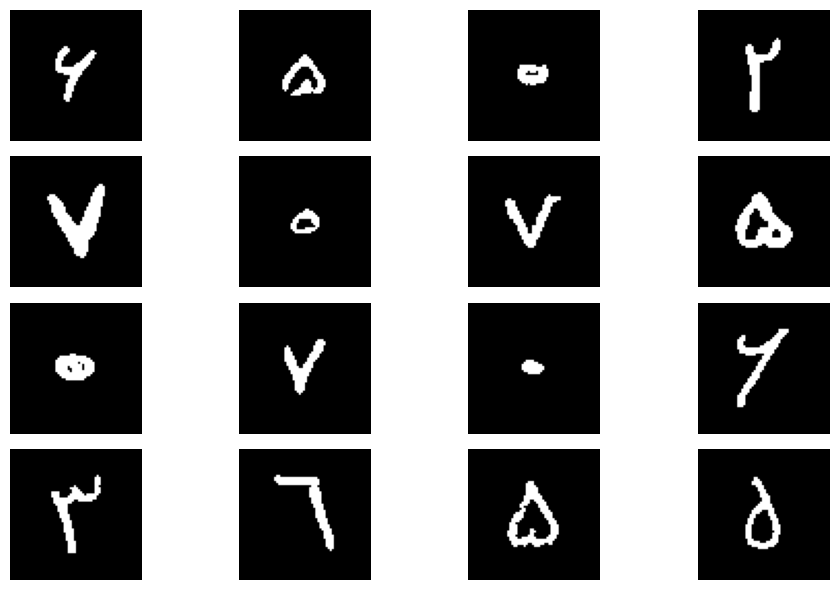

In [112]:
def show_images(num_images, data):
  num_cols = 4
  num_rows = num_images % num_cols

  if num_rows == 0:
    num_rows = num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

  axes = axes.flatten()

  for i in range(num_images):
      axes[i].imshow(data[i], cmap='gray')
      axes[i].axis('off')

  plt.tight_layout()

  plt.show()

show_images(16, new_data1)

In [ ]:
print(labels[:16])

## Feature Extraction

### Zoning

In [113]:
def extract_zoning_features(image, grid_size=(4, 4)):
    zones = []
    rows, cols = grid_size
    height, width = image.shape
    row_size = height // rows
    col_size = width // cols

    for i in range(rows):
        for j in range(cols):
            zone = image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size]
            zone_feature = np.sum(zone > 0)
            zones.append(zone_feature)
    return np.array(zones)

new_data_zoning = np.array([extract_zoning_features(img) for img in new_data1])

### Histogram

In [114]:
def extract_histogram_features(image):
    vertical_hist = np.sum(image, axis=0)
    horizontal_hist = np.sum(image, axis=1)
    return np.concatenate([vertical_hist, horizontal_hist])

new_data_hist = np.array([extract_histogram_features(img) for img in new_data1])

## Classification with MLP

### Train and Test Data

In [115]:
first_index = 50000
last_index = 60000
X_train_zoning = new_data_zoning[:first_index]
X_test_zoning = new_data_zoning[first_index:last_index]

X_train_hist = new_data_hist[:first_index]
X_test_hist = new_data_hist[first_index:last_index]

y_train= labels[:first_index]
y_test= labels[first_index:last_index]

In [116]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_zoning_scaled = scaler.fit_transform(X_train_zoning)
X_test_zoning_scaled = scaler.transform(X_test_zoning)

X_train_hist_scaled = scaler.fit_transform(X_train_hist)
X_test_hist_scaled = scaler.transform(X_test_hist)

### Implementing the MLP Model from scratch

In [117]:
class MLPClassifier :
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        self.weights = []
        self.biases = []

        prev_size = input_size
        for size in hidden_sizes:
            self.weights.append(np.random.randn(prev_size, size) * 0.01)
            self.biases.append(np.zeros(size))
            prev_size = size

        self.weights.append(np.random.randn(prev_size, output_size) * 0.01)
        self.biases.append(np.zeros(output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, x):
        activations = [x]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self.sigmoid(z)
            activations.append(a)
        return activations

    def backward(self, x, y, learning_rate):
        activations = self.forward(x)
        output = activations[-1]

        error = y - output

        delta = error * self.sigmoid_derivative(output)

        weight_deltas = [np.dot(activations[-2].reshape(-1, 1), delta.reshape(1, -1))]
        bias_deltas = [delta]

        for i in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            weight_deltas.insert(0, np.dot(activations[i].reshape(-1, 1), delta.reshape(1, -1)))
            bias_deltas.insert(0, delta)

        for i in range(len(self.weights)):
            self.weights[i] += learning_rate * weight_deltas[i]
            self.biases[i] += learning_rate * np.mean(bias_deltas[i], axis=0)

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            for i in range(len(X)):
                self.backward(X[i], y[i], learning_rate)

            if (epoch + 1) % (epochs/10) == 0:
                predictions = self.predict(X)
                accuracy = np.mean(predictions == y)
                print(f"Epoch {epoch + 1}, Accuracy: {accuracy}")

    def predict(self, X):
        predictions = []
        for x in X:
            activations = self.forward(x)
            output = activations[-1]
            predictions.append(np.argmax(output))
        return np.array(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

In [118]:
# MLP model with one hidden layer for Zoning Features
mlp_manual_zoning = MLPClassifier(input_size=X_train_zoning_scaled.shape[1], hidden_sizes=[128], output_size=10)

mlp_manual_zoning.train(X_train_zoning_scaled, y_train, epochs=100, learning_rate=0.01)

Epoch 10, Accuracy: 0.10000969
Epoch 20, Accuracy: 0.10000969
Epoch 30, Accuracy: 0.1000094328
Epoch 40, Accuracy: 0.1000092636
Epoch 50, Accuracy: 0.1000091544
Epoch 60, Accuracy: 0.1000090084
Epoch 70, Accuracy: 0.100008816
Epoch 80, Accuracy: 0.100008698
Epoch 90, Accuracy: 0.1000085768
Epoch 100, Accuracy: 0.1000084316


In [119]:
accuracy_manual_zoning = mlp_manual_zoning.score(X_test_zoning_scaled, y_test)
print(f'Accuracy with Zoning features: {accuracy_manual_zoning:.4f}')

Accuracy with Zoning features: 0.1000


In [120]:
# MLP model with one hidden layer for Histogram Features
mlp_manual_hist = MLPClassifier(input_size=X_train_hist_scaled.shape[1], hidden_sizes=[128], output_size=10)

mlp_manual_hist.train(X_train_hist_scaled, y_train, epochs=100, learning_rate=0.01)

Epoch 10, Accuracy: 0.100108406
Epoch 20, Accuracy: 0.1002207244
Epoch 30, Accuracy: 0.1002298452
Epoch 40, Accuracy: 0.1002296336
Epoch 50, Accuracy: 0.1002290264
Epoch 60, Accuracy: 0.1002291792
Epoch 70, Accuracy: 0.100225036
Epoch 80, Accuracy: 0.1002291676
Epoch 90, Accuracy: 0.1002471196
Epoch 100, Accuracy: 0.1002673496


In [121]:
accuracy_manual_hist = mlp_manual_hist.score(X_test_hist_scaled, y_test)
print(f'Accuracy with Histogram features: {accuracy_manual_hist:.4f}')

Accuracy with Histogram features: 0.0987


### Implementing the MLP Model Using TensorFlow (Keras)

In [122]:
import tensorflow as tf

In [123]:
# MLP model using Keras for Zoning Features
keras_mlp_zoning = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_zoning_scaled.shape[1]),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [124]:
keras_mlp_zoning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [125]:
# Train the model
history = keras_mlp_zoning.fit(X_train_zoning_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_zoning_scaled, y_test))

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5657 - loss: 1.2998 - val_accuracy: 0.6897 - val_loss: 0.8361
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6986 - loss: 0.8073 - val_accuracy: 0.7047 - val_loss: 0.7785
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7126 - loss: 0.7671 - val_accuracy: 0.7117 - val_loss: 0.7554
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7223 - loss: 0.7423 - val_accuracy: 0.7157 - val_loss: 0.7435
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7248 - loss: 0.7326 - val_accuracy: 0.7218 - val_loss: 0.7310
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7232 - loss: 0.7308 - val_accuracy: 0.7222 - val_loss: 0.7319
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7310 - loss: 0.7172 - val_accuracy: 0.7249 - val_loss: 0.7263
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7302 - loss: 0

In [126]:
# Evaluate the model
test_loss, test_acc = keras_mlp_zoning.evaluate(X_test_zoning_scaled, y_test, verbose=2)
print(f'Test accuracy with MLP model on Zoning Features: {test_acc:.4f}')

313/313 - 0s - 1ms/step - accuracy: 0.7363 - loss: 0.7084
Test accuracy with MLP model on Zoning Features: 0.7363


In [127]:
# MLP model using Keras for Histogram Features
keras_mlp_hist = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_hist_scaled.shape[1]),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [128]:
keras_mlp_hist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [129]:
# Train the model
history = keras_mlp_hist.fit(X_train_hist_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_hist_scaled, y_test))

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6981 - loss: 0.8363 - val_accuracy: 0.8186 - val_loss: 0.4729
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8393 - loss: 0.4416 - val_accuracy: 0.8500 - val_loss: 0.4101
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8616 - loss: 0.3797 - val_accuracy: 0.8642 - val_loss: 0.3645
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8775 - loss: 0.3361 - val_accuracy: 0.8784 - val_loss: 0.3525
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8856 - loss: 0.3149 - val_accuracy: 0.8812 - val_loss: 0.3278
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8950 - loss: 0.2906 - val_accuracy: 0.8837 - val_loss: 0.3188
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8992 - loss: 0.2798 - val_accuracy: 0.8860 - val_loss: 0.3225
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9033 - loss: 0

In [130]:
# Evaluate the model
test_loss, test_acc = keras_mlp_hist.evaluate(X_test_hist_scaled, y_test, verbose=2)
print(f'Test accuracy with MLP model on Zoning Features: {test_acc:.4f}')

313/313 - 0s - 1ms/step - accuracy: 0.9060 - loss: 0.4583
Test accuracy with MLP model on Zoning Features: 0.9060


## Evaluating the Model's Robustness Against Noise and Rotation

### Adding Salt-and-Pepper Noise to the Images

In [131]:
def add_salt_and_pepper_noise(image, amount=0.04):
    noisy_image = np.copy(image)
    total_pixels = image.size
    num_salt = int(total_pixels * amount / 2)
    num_pepper = int(total_pixels * amount / 2)

    # Adding salt noise (white pixels)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 1

    # Adding pepper noise (black pixels)
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0
    return noisy_image

# Adding salt-and-pepper noise to the test images
X_test_noisy = np.array([add_salt_and_pepper_noise(img) for img in new_data1[first_index:last_index]])

# Evaluate the model with noisy images
X_test_noisy_hist = np.array([extract_histogram_features(img) for img in X_test_noisy])
X_test_noisy_hist_scaled = scaler.transform(X_test_noisy_hist)
accuracy_noisy = keras_mlp_hist.evaluate(X_test_noisy_hist_scaled, y_test)
print(f'Accuracy with Salt and Pepper Noise: {accuracy_noisy[1]:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4781 - loss: 8.6390
Accuracy with Salt and Pepper Noise: 0.4876


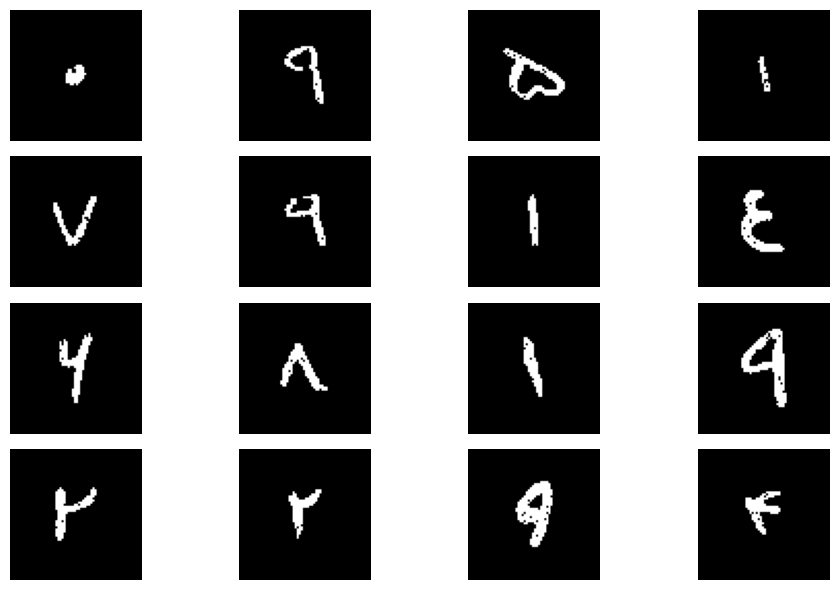

In [132]:
show_images(16, X_test_noisy)

### Rotating the Images and Evaluating the Model

In [133]:
def rotate_image(image, angle):
    center = tuple(np.array(image.shape) / 2)
    matrix = cv2.getRotationMatrix2D(center, np.random.uniform(-angle,angle), 1.0)
    rotated = cv2.warpAffine(image, matrix, image.shape)
    return rotated

Angle = 45

X_test_rotated = np.array([rotate_image(img, Angle) for img in new_data1[first_index:last_index]])
X_test_rotated_hist = np.array([extract_histogram_features(img) for img in X_test_rotated])
X_test_rotated_hist_scaled = scaler.transform(X_test_rotated_hist)
accuracy_rotated = keras_mlp_hist.evaluate(X_test_rotated_hist_scaled, y_test)
print(f'Accuracy with Rotated Images ({Angle} degrees): {accuracy_rotated[1]:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5703 - loss: 8.7960
Accuracy with Rotated Images (45 degrees): 0.5674


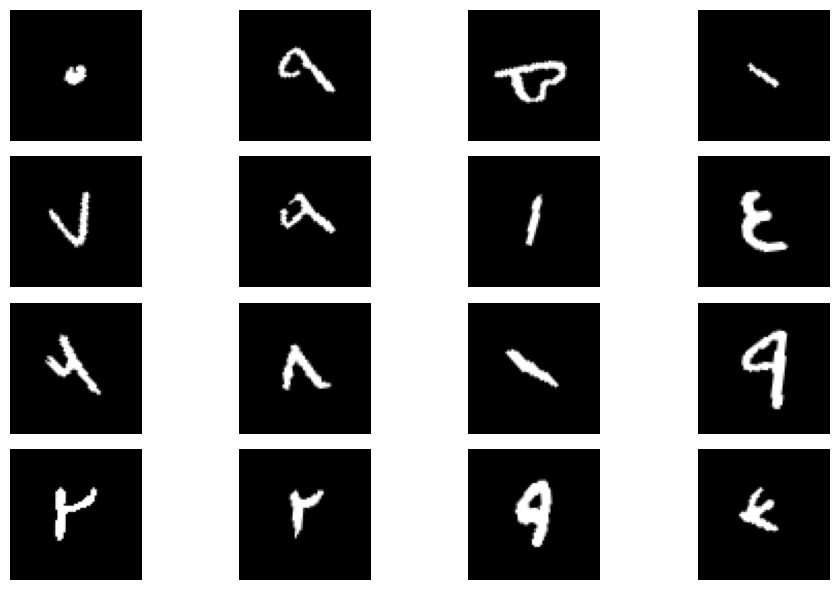

In [134]:
show_images(16, X_test_rotated)